# Hybrid Quantum-Classical Classifier

## Imports

In [1]:
# Standard Library
from tqdm.notebook import trange
from IPython.display import display
from pprint import pprint

# Classical Machine Learning
import torch
from torch import nn, optim
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Qiskit and Quantum Machine Learning
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals

# Local Modules
from lib import get_wine_dataloaders, plot_3d_decision_boundary, judge_wine

## Constants and Setup

In [2]:
EPOCHS = 10
BATCH_SIZE = 1
LEARNING_RATE = 0.001
MODEL_PATH = "misc/model.pt"
SEED = 1

# Seed setup for reproducibility
torch.manual_seed(SEED)
algorithm_globals.random_seed = SEED

## Hybrid Neural Network

In [3]:
def create_qnn():
    """Create a Quantum Neural Network."""
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    return EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )


class QuantumNet(nn.Module):
    """Hybrid Quantum-Classical Neural Network."""

    def __init__(self, qnn):
        super().__init__()
        self.fc1 = nn.Linear(3, 2)
        self.qnn = TorchConnector(qnn)
        self.fc2 = nn.Linear(1, 2)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.qnn(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

## Training and Evaluation Functions

In [4]:
def train_model(train_loader, model, optimizer, loss_func):
    """Train the model."""
    total_samples = len(train_loader.dataset)
    progress_bar = trange(EPOCHS * total_samples // BATCH_SIZE)
    for _ in range(EPOCHS):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(quality=target[0].item(), loss=loss.item())
            progress_bar.update(1)


def evaluate_model(test_loader, model):
    """Evaluate the model."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            y_true.extend(target.numpy())
            y_pred.extend(predicted.numpy())

    # Generate classification report with labels and target_names
    clf_report = classification_report(
        y_true, y_pred, labels=[0, 1], target_names=["Bad Wine", "Good Wine"], output_dict=True
    )

    # Create a DataFrame from the classification report
    clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :].T

    # Use background_gradient for heatmap
    display(clf_report_df.style.background_gradient(cmap="viridis"))

## Data Preparation

In [5]:
train_loader, test_loader, class_weights = get_wine_dataloaders(batch_size=BATCH_SIZE)
class_weights_tensor = torch.tensor(class_weights).float()

## Model and Optimizer setup

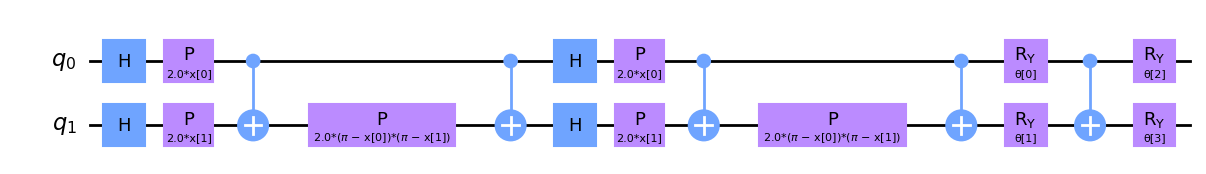

QuantumNet(
  (fc1): Linear(in_features=3, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc2): Linear(in_features=1, out_features=2, bias=True)
)


In [6]:
qnn = create_qnn()
model = QuantumNet(qnn)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = nn.NLLLoss(weight=class_weights_tensor)

display(model.qnn.neural_network.circuit.decompose().draw("mpl"))
pprint(model)

## Training

In [7]:
# Model training
train_model(train_loader, model, optimizer, loss_func)

# Display model

# Model saving
torch.save(model.state_dict(), MODEL_PATH)

  0%|          | 0/12790 [00:00<?, ?it/s]

## Evaluating

In [8]:
# Model loading
model.load_state_dict(torch.load(MODEL_PATH))

# Model parameters
pprint(model.state_dict(), sort_dicts=False)

# Model evaluation
evaluate_model(test_loader, model)

OrderedDict([('fc1.weight',
              tensor([[ 0.3579,  0.0460, -0.2928],
        [ 0.1905,  0.0215, -0.1298]])),
             ('fc1.bias', tensor([0.0796, 0.4966])),
             ('qnn.weight', tensor([-1.2396,  0.5509, -0.0977,  0.5196])),
             ('qnn._weights', tensor([-1.2396,  0.5509, -0.0977,  0.5196])),
             ('fc2.weight', tensor([[ 0.8706],
        [-0.8951]])),
             ('fc2.bias', tensor([-0.0987, -0.0642]))])


,precision,recall,f1-score
Bad Wine,0.660494,0.758865,0.706271
Good Wine,0.784810,0.692737,0.735905
accuracy,0.721875,0.721875,0.721875
macro avg,0.722652,0.725801,0.721088
weighted avg,0.730033,0.721875,0.722847


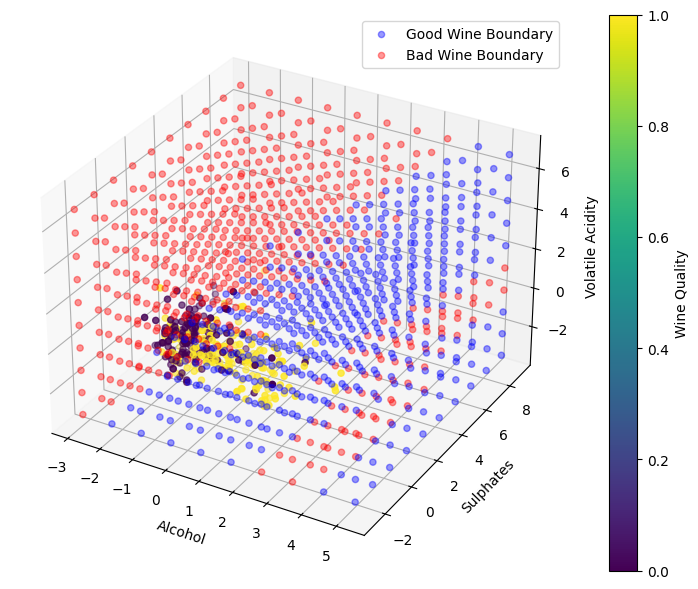

In [9]:
# Plot 3D decision boundary
plot_3d_decision_boundary(model, train_loader, test_loader)

## Quiz

In [10]:
# wine = [alcohol, solphates, volatile acidity]
wine_1 = [0.141, 0.61, 0.47]
wine_2   = [0.135, 0.77, 0.32]
wine_3  = [0.125, 0.55, 0.78]

In [ ]:
print(judge_wine(model, wine_1))
print(judge_wine(model, wine_2))
print(judge_wine(model, wine_3))